In [31]:
import re
import random
import pandas as pd
import hashlib

In [32]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)



cards_to_age['head'] = cards_to_age['head'].str.strip()

# remove headers I don't want anymore
undesired_headers = ['CCH Axcess']
cards_to_age = cards_to_age.loc[~cards_to_age['head'].isin(undesired_headers), :].copy()

cards_to_age['age'] = cards_to_age['age'].fillna(0)

age_factor = 1.01
cards_to_age['age'] = cards_to_age['age'] * age_factor

cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Django', 'PnP PowerShell']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [33]:
ave_order = ('age', 'mean')
sum_order = ('age', 'sum')

stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(ave_order)
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Network Terms,35.505747,2.367050,6.304130,15
"The Mines of the Behemoth, Shea",552.869754,11.283056,27.104124,49
Exchange Online and Defender,662.347021,16.983257,33.863463,39
Docker,664.203289,21.425913,41.470318,31
SSH + SCP,705.296536,24.320570,40.896161,29
GUI Docker Container,733.275040,34.917859,51.381039,21
Linux,1180.197936,36.881186,57.244688,32
"Everything is Tuberculosis, Green",892.462169,38.802703,60.270215,23
WinHex,884.839992,42.135238,57.741843,21
"The Simulacra, Dick",1093.159013,57.534685,76.697119,19


# Histogram

sum of ages: ~57421.21


<Axes: >

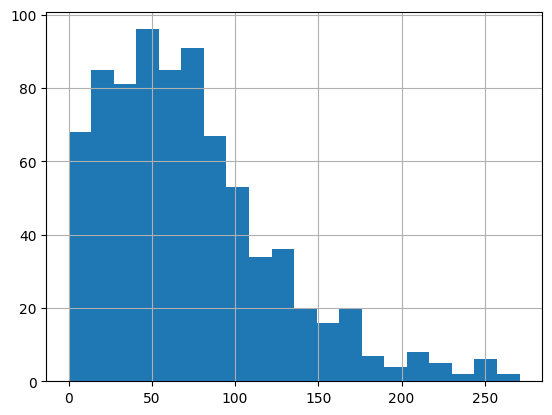

In [34]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~57421.21


<Axes: >

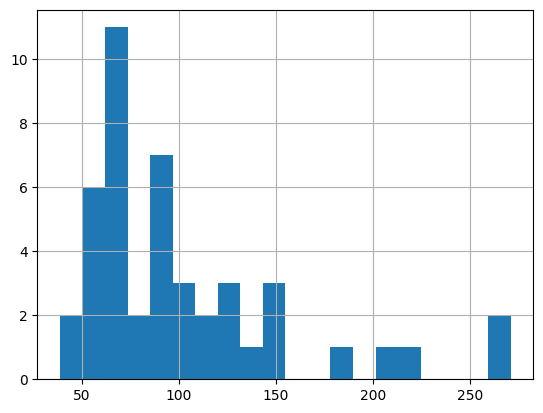

In [35]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Microsoft Purview']['age'].hist(bins=20)

# Completely Random Shuffle

In [36]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [37]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [38]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // m

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [39]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [40]:
# n = random.choice([1, 2, 3, 4, 4, 5])

# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [41]:
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()

choices = ['floor', 'mod']
option = random.choice(choices)
if option == 'floor':
    n=5
    existing_cards['n_fold'] = existing_cards['count'] // n
    print("floor dividing for n-fold")
elif option == 'mod':
    n=3
    existing_cards['n_fold'] = existing_cards['count'] % n
    print("modulo for n-fold")
else: raise NotImplementedError


if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
    existing_cards['subject_highest_age'] *= -1
existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)

modulo for n-fold
Cards found: 786
Total card age: 57421.21


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
0,PnP PowerShell,Remove-PnPFile (PnP.PowerShell)\nDeletes a spe...,82aa6d1579ce68a7efaf6bae61eb3a03,131.614692,131.614692,-131.614692,131.614692,0.619564,1,0,0,-131.614692
1,Accounting,Amortization\nSystematic allocation of the cos...,414cb89a0e514694fbe4916816272b11,253.072898,96.879426,-253.072898,775.035409,0.839146,8,0,0,-253.072898
522,Accounting,Matching Principle\nExpenses are recorded in t...,48333c3b783e67fe267f8c207dc0b487,88.051696,96.879426,-253.072898,775.035409,0.839146,8,3,0,-88.051696
3,Accounting,Intangible Assets\nNon-physical assets with va...,504f63116cc102434702ded20fae46df,58.833003,96.879426,-253.072898,775.035409,0.839146,8,6,0,-58.833003
4,TSQL,Window Functions:\n\nFunctions like ROW_NUMBER...,ed774e26f7161223f8f195315fce87c3,241.046665,101.636136,-241.046665,1219.633629,0.331431,12,0,0,-241.046665
5,TSQL,Q: What happens in T-SQL if you use GROUP BY b...,c3ed24d78b8a70215c7595f33fe32bc7,123.862701,101.636136,-241.046665,1219.633629,0.331431,12,3,0,-123.862701
6,TSQL,Self-Joins for Hierarchies:\n\nUseful for comp...,ead33c6a0051c6b6229a06a68ac14f06,78.521119,101.636136,-241.046665,1219.633629,0.331431,12,6,0,-78.521119
7,TSQL,Q: When should you use window functions instea...,8cad1f805f2826f36ec3874d70c61aff,54.030984,101.636136,-241.046665,1219.633629,0.331431,12,9,0,-54.030984
8,Power BI,Q: Why is a 200 K-row table (40 MB PBIX) unlik...,0af08bf57f17ab4ea91bf8941cafd0a9,224.266502,122.571000,-224.266502,1470.852005,0.706666,12,0,0,-224.266502
9,Power BI,Why might SUMMARIZECOLUMNS yield better perfor...,46e7b55df538b828c02c3231354001bc,162.062873,122.571000,-224.266502,1470.852005,0.706666,12,3,0,-162.062873



## Random

In [42]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [43]:
existing_cards.head(10)['age'].sum()

np.float64(1415.3631350431338)

In [44]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold,neg_age
195,Microsoft Purview,"You can configure your policies so that, when ...",1bc3c328bf07dac54524eadc58cfa328,270.897514,102.099327,-270.897514,4594.469737,0.405602,45,0,0,-270.897514
454,Microsoft Purview,"When you create your DLP policies, you should ...",8ec1edc0f421bb7de2884cb3c7089b3e,261.462375,102.099327,-270.897514,4594.469737,0.405602,45,1,1,-261.462375
146,Terraform Codebox,Lifecycle blocks let you fine-tune resource be...,0f442d63063c2560ae76af631c6b9d12,254.916640,115.045926,-254.916640,4141.653330,0.708779,36,0,0,-254.916640
405,Terraform Codebox,corepack pnpm test\nA command pattern used to ...,85012d4ed6b5e32d36886a085cc48197,254.279054,115.045926,-254.916640,4141.653330,0.708779,36,1,1,-254.279054
1,Accounting,Amortization\nSystematic allocation of the cos...,414cb89a0e514694fbe4916816272b11,253.072898,96.879426,-253.072898,775.035409,0.839146,8,0,0,-253.072898
60,"Mexican Gothic, Moreno-Garcia",traceries (TRAY-suh-reez)\nnoun\nDelicate orna...,3720f358b6a22134861965f53caa4c3e,250.571025,90.169401,-250.571025,2524.743217,0.587019,28,0,0,-250.571025
24,Python + Oauth2.0,authorize_url\n\nThe endpoint where the user i...,6a264f45c613880c60d7986e3d683448,250.214350,118.052986,-250.214350,2243.006738,0.729992,19,0,0,-250.214350
288,Python + Oauth2.0,"(""localhost"", 8080)\n\nThe address tuple passe...",d33808d12096e5298b1e5c8617c745a4,244.306602,118.052986,-250.214350,2243.006738,0.729992,19,1,1,-244.306602
4,TSQL,Window Functions:\n\nFunctions like ROW_NUMBER...,ed774e26f7161223f8f195315fce87c3,241.046665,101.636136,-241.046665,1219.633629,0.331431,12,0,0,-241.046665
12,CCH Tax Forms Project,Disabling GenerateMeta in CCH Axcess export op...,0881e21379d3a9f0ad63b7c4f20a58f9,235.920894,108.498283,-235.920894,1844.470806,0.853415,17,0,0,-235.920894


In [45]:
f"Average age: {abs(existing_cards['age'].mean()):.3f}"

'Average age: 73.055'